# РК №2 Лаврик Даниил Дмитриевич ИУ5-65Б Вариант 8

Задание. Для заданного набора данных (googleplaystore.csv) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (1:Метод опорных векторов, 2:Градиентный бустинг). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm

Проведем предварительную подготовку датасета: удаление пропусков + кодирование категориальных признаков

In [2]:
data = pd.read_csv("googleplaystore.csv")

In [3]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
data = data.dropna(axis=0)
data.shape

(9360, 13)

Типы переменных в датасете до обработки

In [5]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Кодируем категориальные признаки в числовые:

In [6]:
for i in range(data.shape[0]):
    data["Reviews"].iloc[i] = int(data["Reviews"].iloc[i])
    str = data["Installs"].iloc[i][:-1]
    data["Installs"].iloc[i] = int(str.replace(",", ""))
    if data["Price"].iloc[i] != "0":
        data["Price"].iloc[i] = data["Price"].iloc[i][1:]
        data["Price"].iloc[i] = float(data["Price"].iloc[i])
    else:
        data["Price"].iloc[i] = 0
data = data.astype({"Reviews": "int64"})
data = data.astype({"Installs": "int64"})
data = data.astype({"Price":"float64"})

leType = LabelEncoder()
le_arr = leType.fit_transform(data["Type"])
data["Type"] = le_arr
data = data.astype({"Type":"int64"})

leContent = LabelEncoder()
le_arr = leContent.fit_transform(data["Content Rating"])
data["Content Rating"] = le_arr
data["Content Rating"].unique()
data = data.astype({"Content Rating":"int64"})

leCategory = LabelEncoder()
le_arr = leCategory.fit_transform(data["Category"])
data["Category"] = le_arr
data["Category"].unique()
data = data.astype({"Category":"int64"})

leGenres = LabelEncoder()
le_arr = leGenres.fit_transform(data["Genres"])
data["Genres"] = le_arr
data["Genres"].unique()
data = data.astype({"Genres":"int64"})

leSize = LabelEncoder()
le_arr = leSize.fit_transform(data["Size"])
data["Size"] = le_arr
data["Size"].unique()
data = data.astype({"Size":"int64"})

C:\Users\igrun\AppData\Local\Temp\ipykernel_34356\2551760661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Reviews"].iloc[i] = int(data["Reviews"].iloc[i])
C:\Users\igrun\AppData\Local\Temp\ipykernel_34356\2551760661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Installs"].iloc[i] = int(str.replace(",", ""))
C:\Users\igrun\AppData\Local\Temp\ipykernel_34356\2551760661.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

Название приложения, дата его обновления и версии андроида - признаки с большим количеством уникальных значений, не нужные для исследований. Удалим их.

In [7]:
data2 = data.drop(["App", "Last Updated", "Current Ver", "Android Ver"], axis=1)

In [8]:
data2.dtypes

Category            int64
Rating            float64
Reviews             int64
Size                int64
Installs            int64
Type                int64
Price             float64
Content Rating      int64
Genres              int64
dtype: object

Построим матрицу корреляции:

<Axes: >

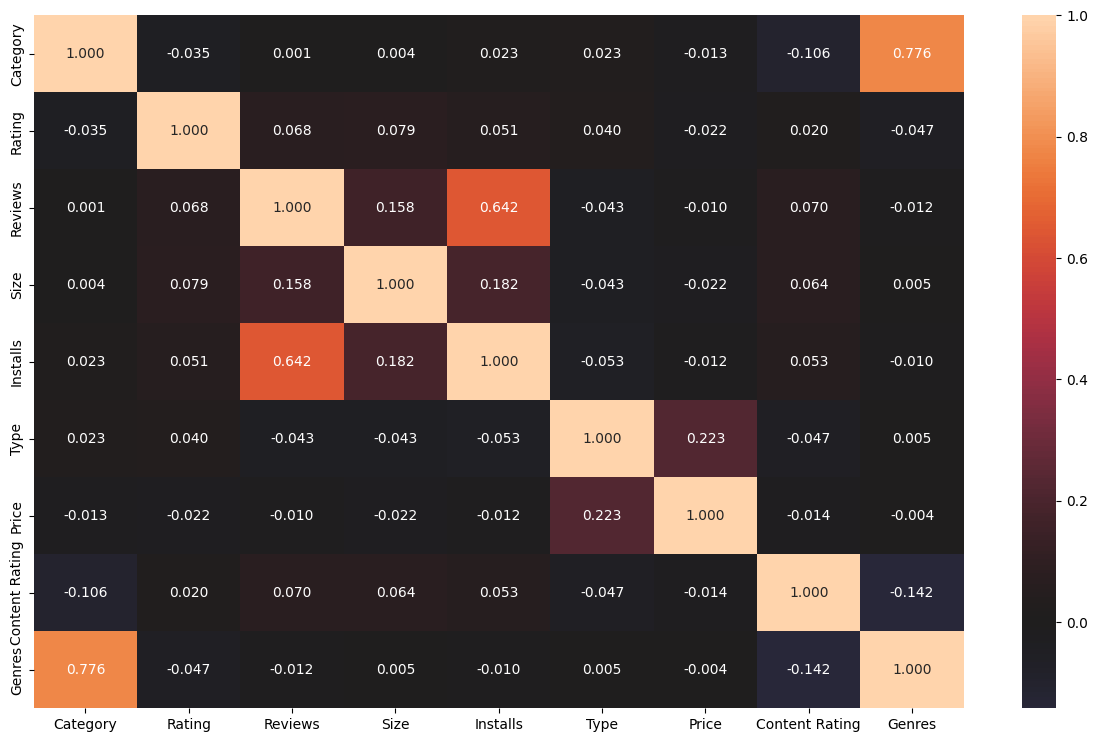

In [9]:
fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(data2.corr(method="pearson"), ax=ax,annot=True, fmt=".3f", center=0)

В качестве целевого признака возьмём столбец "Genres" - жанры игр в Google Play Store

In [10]:
#Разделение выборки на обучающую и тестовую
target = "Genres"
xArray = data2.drop(target, axis=1)
yArray = data2[target]
trainX, testX, trainY, testY = train_test_split(xArray, yArray, test_size=0.2, random_state=1)

### Метод опорных векторов

In [11]:
svr = svm.SVR()
svr.fit(trainX, trainY)
svr_pred = svr.predict(testX)
svr_pred

array([68.09892979, 65.20483514, 64.89307112, ..., 64.90563683,
       64.92133232, 64.89307672])

### Градиентный бустинг для регрессии
Будем использовать функцию GradientBoostingRegressor из библиотеки ScikitLearn

In [12]:
grad_boost = GradientBoostingRegressor()
grad_boost.fit(trainX, trainY.to_numpy().flatten())
grad_boost_pred = grad_boost.predict(testX)
grad_boost_pred

array([35.2449918 , 37.7562945 , 62.24301161, ..., 50.66982123,
       52.66560839, 53.1279504 ])

Оценка моделей с использованием метрик среднеквадратичной ошибки (MSE) и коэффициента детерминации (R-squared)

In [13]:
svr_mse = mean_squared_error(testY, svr_pred)
svr_r2 = r2_score(testY, svr_pred)

In [14]:
grad_boost_mse = mean_squared_error(testY, grad_boost_pred)
grad_boost_r2 = r2_score(testY, grad_boost_pred)

In [15]:
print("SVR")
print("Mean Squared Error (MSE):", svr_mse)
print("R-squared:", svr_r2)

SVR
Mean Squared Error (MSE): 1089.57877001604
R-squared: -0.0242368622337088


In [16]:
print("GradientBoosting")
print("Mean Squared Error (MSE):", grad_boost_mse)
print("R-squared:", grad_boost_r2)

GradientBoosting
Mean Squared Error (MSE): 299.91874908107786
R-squared: 0.718067342226813


Вывод: модель градиентного бустинга является более точной, так как у данной модели среднеквадратичная ошибка (MSE) меньше, чем у модели SVR, а коэффициент детерминации (R-squared) ближе к 1.
